<a href="https://colab.research.google.com/github/immischein/ML-bandgap/blob/main/model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
import shap



# Data Imports and Processing


In [ ]:
# Load the JSON data
with open("materials_data.json") as f:
    materials_data = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'materials_data.json'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/ColabImports')

df = pd.read_csv('/content/drive/MyDrive/bandgap_dataset_premium.csv')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,material_id,band_gap,formula,density,volume,a,b,c,alpha,beta,...,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm,bulk_modulus,shear_modulus
0,mp-11107,3.5226,Ac2O3,9.109130,91.511224,4.095487,4.095489,6.299882,90.000000,90.000000,...,103.368761,1.900,0.95,2.47,1.52,0.465403,4.5896,8.1122,"{'voigt': 106.531, 'reuss': 96.061, 'vrh': 101...","{'voigt': 42.704, 'reuss': 28.813, 'vrh': 35.758}"
1,mp-32800,2.2962,Ac2S3,6.535149,1118.407852,14.997851,14.997851,14.997851,144.742139,144.742139,...,95.498257,2.068,0.67,2.47,1.80,0.328232,4.8014,7.0976,NaN,NaN
2,mp-977351,3.0275,Ac2S3,5.562971,328.464893,7.619779,7.619773,7.875664,118.930903,61.069136,...,95.498257,2.068,0.67,2.47,1.80,0.328232,2.9069,5.9344,NaN,NaN
3,mp-867311,0.0794,AcAgTe2,7.997421,122.518406,5.574922,5.574922,5.574922,60.000000,60.000000,...,46.591170,2.175,0.41,2.47,2.06,0.171537,5.9961,6.0755,NaN,NaN
4,mp-1183115,4.1024,AcAlO3,8.728230,57.451413,3.858634,3.858634,3.858634,90.000000,90.000000,...,83.410543,1.774,0.95,2.47,1.52,0.369410,6.8036,10.9060,NaN,NaN


In [ ]:
# To test script: load dummy data

#from sklearn.datasets import fetch_openml

# Load a regression dataset from OpenML
#data = fetch_openml(name="house_prices", as_frame=True)  # Ames housing data
#df = data.frame

# Rename target to match our script
#df = df.rename(columns={"SalePrice": "band_gap"})

In [ ]:
df.head()

,material_id,band_gap,formula,density,volume,a,b,c,alpha,beta,...,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm,bulk_modulus,shear_modulus
0,mp-11107,3.5226,Ac2O3,9.109130,91.511224,4.095487,4.095489,6.299882,90.000000,90.000000,...,103.368761,1.900,0.95,2.47,1.52,0.465403,4.5896,8.1122,"{'voigt': 106.531, 'reuss': 96.061, 'vrh': 101...","{'voigt': 42.704, 'reuss': 28.813, 'vrh': 35.758}"
1,mp-32800,2.2962,Ac2S3,6.535149,1118.407852,14.997851,14.997851,14.997851,144.742139,144.742139,...,95.498257,2.068,0.67,2.47,1.80,0.328232,4.8014,7.0976,NaN,NaN
2,mp-977351,3.0275,Ac2S3,5.562971,328.464893,7.619779,7.619773,7.875664,118.930903,61.069136,...,95.498257,2.068,0.67,2.47,1.80,0.328232,2.9069,5.9344,NaN,NaN
3,mp-867311,0.0794,AcAgTe2,7.997421,122.518406,5.574922,5.574922,5.574922,60.000000,60.000000,...,46.591170,2.175,0.41,2.47,2.06,0.171537,5.9961,6.0755,NaN,NaN
4,mp-1183115,4.1024,AcAlO3,8.728230,57.451413,3.858634,3.858634,3.858634,90.000000,90.000000,...,83.410543,1.774,0.95,2.47,1.52,0.369410,6.8036,10.9060,NaN,NaN


In [ ]:
# Data inspection

print("Data shape:", df.shape)

missing = df.isnull().sum()
missing = missing[missing > 0]
print("Missing values per column:")
for col, n in missing.items():
    print(f"{col}: {n}")

display(df.describe())

Data shape: (82998, 40)
Missing values per column:
formula: 1
avg_en: 9
max_en: 9
min_en: 9
std_en: 9
vbm: 876
cbm: 876
bulk_modulus: 79092
shear_modulus: 79092


,band_gap,density,volume,a,b,c,alpha,beta,gamma,n_atoms,...,max_am,min_am,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm
count,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,...,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82122.000000,82122.000000
mean,1.984421,4.061805,668.913474,7.669236,8.044636,11.280915,86.028830,88.065828,89.700249,42.406058,...,110.699981,17.901714,31.772083,1.769480,0.787753,2.316020,1.528267,0.290510,1.585835,3.591381
std,1.560981,1.717274,693.624420,3.177138,2.800604,6.822619,17.420383,15.977789,22.074143,40.632079,...,57.428377,18.988597,20.400828,0.193034,0.380579,0.355453,0.203977,0.132925,2.238984,2.214685
min,0.000000,0.020144,11.286588,2.363000,2.363000,2.395898,3.664087,5.397478,5.397478,1.000000,...,1.007940,1.007940,0.000000,1.100000,0.000000,1.100000,1.100000,0.000000,-14.222600,-7.360600
25%,0.653400,2.913572,254.760639,5.553544,6.015389,7.389807,77.756958,88.952439,86.976837,16.000000,...,55.845000,6.941000,15.265807,1.666000,0.540000,2.070000,1.520000,0.207338,0.166850,2.368150
50%,1.728450,3.773981,452.574159,7.012094,7.718989,9.712402,90.000000,90.000000,90.000000,29.000000,...,106.420000,15.999400,26.508649,1.729333,0.720000,2.230000,1.520000,0.267822,1.629350,3.660450
75%,3.013225,4.954535,841.664286,8.965331,9.328646,13.157808,90.000000,90.000000,99.717832,54.000000,...,151.964000,15.999400,45.960918,1.855000,0.970000,2.430000,1.520000,0.348872,2.952475,4.974900
max,17.891400,18.889325,20090.906408,46.210701,61.125585,211.425839,169.783994,169.783994,168.048246,444.000000,...,244.000000,227.000000,107.897541,3.430000,2.330000,3.430000,3.430000,1.165000,12.376100,14.341400


# Define features and target

In [ ]:
target_column = "band_gap"
X = df.drop(columns=[target_column])
y = df[target_column]

# Seperate numeric and categorical columns

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocessing

In [ ]:
# To decide: drop columns with >65% missing values (can be lower, based on this dummy dataset)

threshold = 0.65
missing_frac = df.isnull().mean()
cols_to_drop = missing_frac[missing_frac > threshold].index

print(f"Dropping columns with >{int(threshold*100)}% missing values:")
print(list(cols_to_drop))

df = df.drop(columns=cols_to_drop)

# To decide: impute missing numerical values with mean, categorical features with most frequent value
# StandardScaler subtracts mean and divides by std
# Use onehotencoder for categorical features

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)






Dropping columns with >65% missing values:
['bulk_modulus', 'shear_modulus']


# Define the models to compare

In [ ]:
models = {
    "Dummy": DummyRegressor(),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge()}
#    "Random Forest": RandomForestRegressor(random_state=42)
#}

# Model training

In [ ]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# train models
print("\nCross-validated MAE (5-fold):")
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    scores = cross_val_score(pipeline, X_train, y_train,
                             scoring="neg_mean_absolute_error", cv=5)
    print(f"{name}: MAE = {-np.mean(scores):.3f}")


Cross-validated MAE (5-fold):
Dummy: MAE = 1.284
Linear Regression: MAE = 0.055
Ridge Regression: MAE = 0.058


# Evaluate model


Test set performance:
Dummy: MAE = 1.277, R² = -0.000
Linear Regression: MAE = 0.054, R² = 0.988
Ridge Regression: MAE = 0.057, R² = 0.988


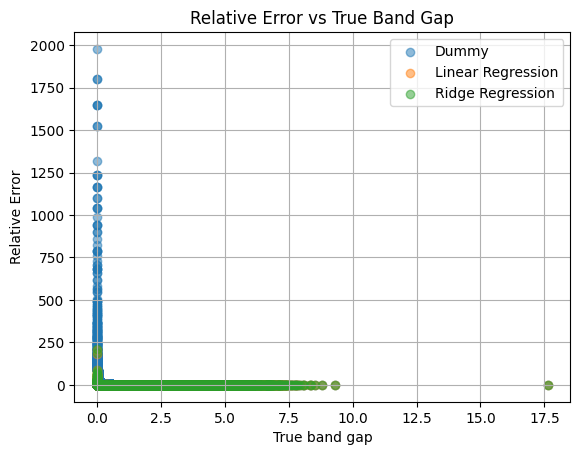

In [ ]:
# Fit on full training set and evaluate on test set

results = {}
print("\nTest set performance:")
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"mae": mae, "r2": r2}

    print(f"{name}: MAE = {mae:.3f}, R² = {r2:.3f}")

    # Plot MAE vs true value
    relative_error = np.abs(y_pred - y_test) / y_test
    plt.scatter(y_test, relative_error, label=name, alpha=0.5)

    #plt.scatter(y_test, np.abs(y_pred - y_test), label=name, alpha=0.5)

plt.xlabel("True band gap")
plt.ylabel("Relative Error")
plt.title("Relative Error vs True Band Gap")
plt.legend()
plt.grid(True)
plt.show()


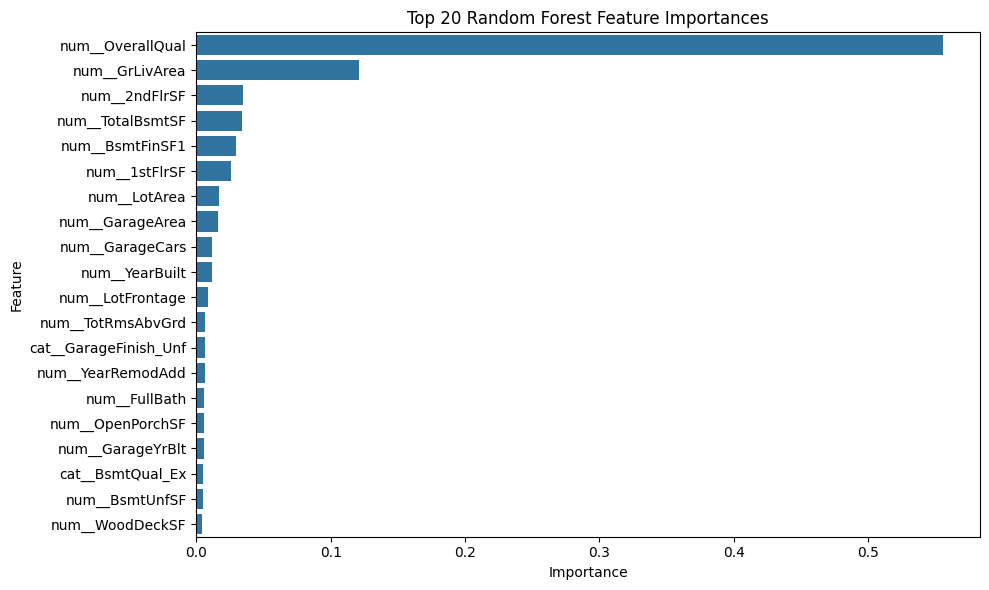

In [ ]:
# Feature importance of tree based model
rf_model = make_pipeline(preprocessor, RandomForestRegressor(random_state=42))
rf_model.fit(X_train, y_train)

importances = rf_model.named_steps["randomforestregressor"].feature_importances_

# Get feature names from the preprocessor
feature_names = rf_model.named_steps["columntransformer"].get_feature_names_out()

# Sort by importance
sorted_idx = np.argsort(importances)[::-1][:20]
top_features = np.array(feature_names)[sorted_idx]
top_importances = importances[sorted_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features)
plt.title("Top 20 Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


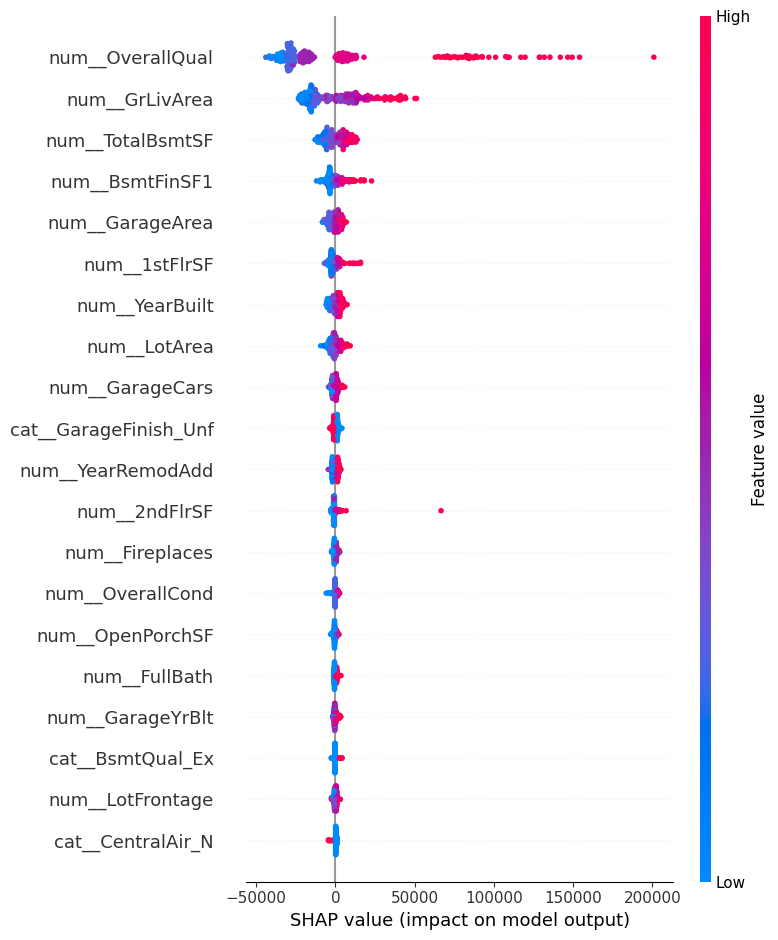

In [ ]:
# Feature importance using SHAP
rf = rf_model.named_steps["randomforestregressor"]
X_transformed = rf_model.named_steps["columntransformer"].transform(X_test)

if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

feature_names = rf_model.named_steps["columntransformer"].get_feature_names_out()

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_transformed)

shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)


# Deep Learning Code

In [ ]:
class Bandgaps_Regression(torch.nn.Module):
    def __init__(self):
        super(Bandgaps_Regression, self).__init__()
        self.linear = torch.nn.Linear(2,1)

    def forward(self,x):
        y = torch.sigmoid(self.linear(x))
        return y

In [ ]:
model = Bandgaps_Regression()

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:

model.train()

for epoch in range(200000):
    optimizer.zero_grad()

    # forward pass
    Y_pred = model(X_tensor)

    # compute loss
    loss = criterion(Y_pred, T_tensor)
    if epoch% 1000 == 0:
        print(loss.item())
    # backward pass
    loss.backward()
    optimizer.step()

NameError: name 'X_tensor' is not defined